### Imports

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

### Dataset 

source: https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature


In [2]:
train_df = pd.read_csv("measures_v2.csv")



In [3]:
train_df.isna().sum()

u_q               0
coolant           0
stator_winding    0
u_d               0
stator_tooth      0
motor_speed       0
i_d               0
i_q               0
pm                0
stator_yoke       0
ambient           0
torque            0
profile_id        0
dtype: int64

There are no unknown values

In [4]:
train_dataset = train_df.sample(frac=0.9, random_state=0)
test_dataset = train_df.drop(train_dataset.index)

Train/test split 90/10

In [5]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
u_q,54.286518,44.178713
coolant,36.235475,21.788244
stator_winding,66.337485,28.670626
u_d,-25.136717,63.075460
stator_tooth,56.876814,22.952563
motor_speed,2202.132107,1859.830500
i_d,-68.695947,64.922478
i_q,37.397639,92.150979
pm,58.505584,18.999829
stator_yoke,48.189194,19.991925


pm-Permanent magnet temperature will be the target variable


In [6]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('pm')
test_labels = test_features.pop('pm')

### Normalization Layer


In [7]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [8]:
normalizer.adapt(np.array(train_features))

In [9]:
print(normalizer.mean.numpy().transpose())

[[  54.287]
 [  36.235]
 [  66.337]
 [ -25.137]
 [  56.877]
 [2202.138]
 [ -68.696]
 [  37.398]
 [  48.189]
 [  24.565]
 [  31.091]
 [  40.794]]


In [10]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('One example:', first.transpose())
  print('Normalized:', normalizer(first).numpy().transpose())

One example: [[  41.94]
 [  18.74]
 [  66.68]
 [-123.48]
 [  46.08]
 [4749.96]
 [-187.96]
 [  77.64]
 [  33.17]
 [  20.55]
 [  74.87]
 [  31.  ]]
Normalized: [[-0.28]
 [-0.8 ]
 [ 0.01]
 [-1.56]
 [-0.47]
 [ 1.37]
 [-1.84]
 [ 0.44]
 [-0.75]
 [-2.08]
 [ 0.57]
 [-0.39]]


### Training

In [30]:
model = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 12)               25        
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 64)                832       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,082
Trainable params: 5,057
Non-trainable params: 25
_________________________________________________________________


In [36]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="mae")
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)]

In [37]:

history = model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=1,
    validation_split = 0.2,
    callbacks=callbacks)

Epoch 1/100
29944/29944 [==============================] - 22s 739us/step - loss: 3.3735 - val_loss: 3.3047
Epoch 2/100
29944/29944 [==============================] - 22s 731us/step - loss: 3.0512 - val_loss: 2.9068
Epoch 3/100
29944/29944 [==============================] - 22s 720us/step - loss: 2.9017 - val_loss: 2.8027
Epoch 4/100
29944/29944 [==============================] - 21s 705us/step - loss: 2.8028 - val_loss: 2.8841
Epoch 5/100
29944/29944 [==============================] - 21s 704us/step - loss: 2.7312 - val_loss: 2.6771
Epoch 6/100
29944/29944 [==============================] - 21s 705us/step - loss: 2.6651 - val_loss: 2.7601
Epoch 7/100
29944/29944 [==============================] - 22s 726us/step - loss: 2.6138 - val_loss: 2.5922
Epoch 8/100
29944/29944 [==============================] - 23s 757us/step - loss: 2.5710 - val_loss: 2.5331
Epoch 9/100
29944/29944 [==============================] - 23s 757us/step - loss: 2.5350 - val_loss: 2.5451
Epoch 10/100
29944/29944 [==

In [46]:
evaluation=model.evaluate( test_features, test_labels, verbose=1)

4159/4159 [==============================] - 2s 558us/step - loss: 1.7565


In [38]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 4])
  plt.xlabel('Epoch')
  plt.ylabel('Error [PM]')
  plt.legend()
  plt.grid(True)

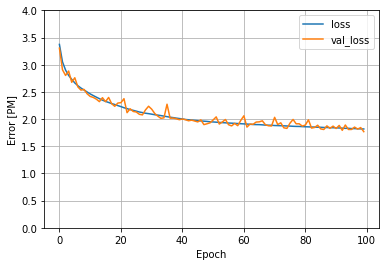

In [39]:
plot_loss(history)

### Model Save

In [53]:
if os.path.isdir("./saved_model") and os.path.isdir("./saved_model_weights") is False:
    os.mkdir("./saved_model")
    os.mkdir("./saved_model_weights")
    
model.save(f'./saved_model/model_1.h5')
model.save(f'./saved_model_weights/model_1.h5')